# Conv2D 25 branches architecture

In [1]:
import tensorflow as tf
print(tf.__version__)
#python -c "import tensorflow as tf;print(tf.__version__)"

2.2.0


In [2]:
#Select GPU 0 or 1
GPU = 1      # Or 0,1, 2, 3, etc.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)  

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(os.getcwd())  #print path

Num GPUs Available:  1
/eos/home-f/frehm/TF2/Skripts/F02-03/Runs/Conv2D/GitHub scripts/Conv2D_25_branches


In [3]:
#set parameters
save_folder = "TF_K_1"         #Name of the Folder in which the results schould be safed

train_file_by_file = True              #True if you want to import the trainingsdata file by file
train_on_folder = False                #True if you want to train on all data files within this folder, False if you want to train just with one file
train_data_path = "/eos/home-f/frehm/TF2/Data/EleEscan_1_1/EleEscan_1_1.h5" #file
train_folder_path = "/eos/home-f/frehm/TF2/Data//"     #there has to be a folder inside
train_file_by_file_path = "/data/frehm/File_by_file/"                  #data on GPU

lrate_g = 0.0005
lrate_d = 0.00010   #lr_d should be roughly the same as the ratio from g to d parameters
nb_epochs = 30
percent = 100                      #take just 10 percent of all data for training and testing
nb_train_files = 20           #20
ReLU_epoch = 3
save_only_best_weights = True
latent_size = 200
batch_size =  128                   #128     #batch_size must be less or equal test size, otherwise error
keras_dformat = 'channels_last'    #last for CPU, first for GPU
wtf = 6.0                           #weight true fake loss
wa = 0.2                            #weight auxiliary loss
we = 0.1                            #weight ecal loss


from PTF_m1_25path import *
from Functions_v1_5_6 import *


In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import print_function
from collections import defaultdict
try:
    import cPickle as pickle
except ImportError:
    import pickle
import argparse
import os
from six.moves import range
import sys
import h5py 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import math as math

In [5]:
generator(keras_dformat=keras_dformat).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 125)          25125       input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 5, 5, 5)      0           dense[0][0]                      
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 15, 15, 32)   4032        reshape[0][0]                    
______________________________________________________________________________________________

leaky_re_lu_103 (LeakyReLU)     (None, 25, 25, 16)   0           conv2d_103[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_108 (LeakyReLU)     (None, 25, 25, 16)   0           conv2d_108[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_113 (LeakyReLU)     (None, 25, 25, 16)   0           conv2d_113[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_118 (LeakyReLU)     (None, 25, 25, 16)   0           conv2d_118[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_123 (LeakyReLU)     (None, 25, 25, 16)   0           conv2d_123[0][0]                 
__________________________________________________________________________________________________
batch_norm

In [6]:
discriminator(keras_dformat=keras_dformat).summary()

(None, 9, 9, 9)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 25, 25, 25,  0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 25, 25, 25)   0           input_2[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 25, 25, 25)   0           reshape_2[0][0]                  
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 25, 25, 25)   0           reshape_2[0][0]                  
____________________________________________________________________________

In [7]:
#create output folders for saving files and weights
create_folder(save_folder+'/')
create_folder(save_folder+'/Weights/')
create_folder(save_folder+'/Weights/disc')
create_folder(save_folder+'/Weights/gen')
create_folder(save_folder+'/Pickle/')
create_folder(save_folder+'/Save_Images/')
print('*************************************************************************************')

#import trainingsdata
if train_file_by_file == False:
    X,y = import_data(train_on_folder, train_data_path, train_folder_path)
    print('*************************************************************************************') 

    #do data preperation    
    X_train, X_test, y_train, y_test, ecal_train, ecal_test, nb_train, nb_test = data_preperation(X, y, keras_dformat, batch_size, percent)
    y_train = np.expand_dims(y_train, axis=-1)  #macht jeden Eintrag in der Liste zu einer Unterliste [1,2,3]->[[1],[2],[3]]
    y_test  = np.expand_dims(y_test,  axis=-1)
    X_train = tf.constant(X_train)
    X_test  = tf.constant(X_test)
    y_train = np.expand_dims(y_train, axis=-1)  #macht jeden Eintrag in der Liste zu einer Unterliste [1,2,3]->[[1],[2],[3]]
    y_test  = np.expand_dims(y_test,  axis=-1)
    y_train = tf.constant(y_train)
    y_test  = tf.constant(y_test)
    ecal_train = tf.constant(ecal_train)
    ecal_test  = tf.constant(ecal_test)
    print("X_train_shape: ", X_train.shape)
    print("X_test_shape: ", X_test.shape)
    print("ecal_train_shape: ", ecal_train.shape)
    print("ecal_test_shape: ", ecal_test.shape)
    print('*************************************************************************************')
else:
    files = create_files_list(train_file_by_file_path)
    X_test = []
    y_test = []
    ecal_test = []

Directory  TF_K_1/  already exists
Directory  TF_K_1/Weights/  already exists
Directory  TF_K_1/Weights/disc  already exists
Directory  TF_K_1/Weights/gen  already exists
Directory  TF_K_1/Pickle/  already exists
Directory  TF_K_1/Save_Images/  already exists
*************************************************************************************


In [8]:
#discriminator.build()
discriminator = discriminator(keras_dformat = keras_dformat)
generator = generator(keras_dformat = keras_dformat, latent_size = 200)
#generator = tf.saved_model.load(save_folder + "/Generator")
#print(discriminator.trainable_variables)
#print(generator.trainable_variables)

(None, 9, 9, 9)


In [9]:
#load best weights
#load_path = "/eos/home-f/frehm/TF2/Skripts/F02-03/Runs/Conv2D/Optuna/v4_5_briderparameterrange/Search_1/Trial_8/"
#epoch = str(7)
#gweights = load_path + "Weights/gen/params_generator_epoch_" + epoch + ".hdf5"
#dweights = load_path + "Weights/disc/params_discriminator_epoch_"+ epoch +".hdf5"
#generator.load_weights(gweights)
#discriminator.load_weights(dweights)

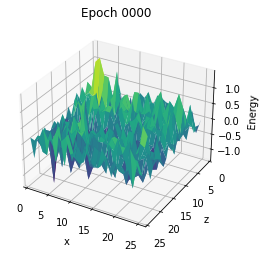

In [10]:
#define plots during training after each epoch

#%matplotlib notebook            #this is for 3D projection
epoch=0

#function for plotting a training images
if train_file_by_file == False:
    plot_images(X, epoch, save_folder, save=False, number=1)

def plot_gen_image_tf(latent_size, epoch=0):   #generate a image 
    tf.random.set_seed(1)     
    noise, gen_aux, generator_input, gen_ecal = func_for_gen(1,latent_size=latent_size)
    tf.random.set_seed(None)
    generated_images = generator(generator_input)
    try:
        generated_images = np.squeeze(generated_images, axis=(1,))
    except:
        generated_images = np.squeeze(generated_images, axis=(-1,))
    Xgen = generated_images
    plot_images(Xgen, epoch, save_folder, save=True, number=1)
    return

plot_gen_image_tf(latent_size)

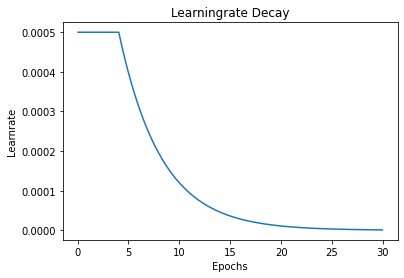

lr last value:  0.0


In [11]:
#learningrate decay with epochs
def l_dec(initial_lrate, epoch, start_decay=80, decay_rate=0.012):
    epoch = epoch - 1 #because training starts at epoch 1
    if epoch < start_decay:
        k = 0.0
    else:
        k = decay_rate #0.07
        epoch = epoch - start_decay
    lrate = initial_lrate * math.exp(-k*epoch)
    return lrate

ep_list=[]
lr_list=[]
for i in range(1,nb_epochs*20):
    ep_list.append(i)
    lr_list.append(l_dec(lrate_g, i))
ep_list = [i / 20 for i in ep_list]

plt.plot(ep_list,lr_list)
plt.title("Learningrate Decay")
plt.xlabel("Epochs")
plt.ylabel("Learnrate")
plt.show()
print("lr last value: ", round(lr_list[-1],5))
#print(lr_list)

In [12]:
#run validation script
#validation_metric = validate(generator, percent=10, keras_dformat=keras_dformat, data_path=train_file_by_file_path)

In [13]:
#Gromov-Wasserstein Validation
#https://github.com/svalleco/3Dgan/blob/Anglegan/keras/misc/GromovWass.py#L287

#Gromov_Wasserstein_distance = analyse(generator, read_data=False, save_data=False, gen_weights="", data_path=train_file_by_file_path,
#       sorted_path="", optimizer = Gromov_metric)
#print('Gromov-Wasserstein distances: ' + str(Gromov_Wasserstein_distance))

In [ ]:
#training
verbose = 'true'

train_history = defaultdict(list)   #create a dict with an empty list 
test_history = defaultdict(list)

start_epoch = 1             #i want to start traing at epoch 1
for epoch in range(start_epoch, nb_epochs + 1):
    print('Epoch {} of {}'.format(epoch, nb_epochs))
    start_epoch = time.time()
    lr_d = l_dec(lrate_d, epoch)
    lr_g = l_dec(lrate_g, epoch)
    optimizer_d = tf.optimizers.Adam(lr_d)
    optimizer_g = tf.optimizers.Adam(lr_g)
    #nb_batches = int(X_train.shape[0] / batch_size)
    epoch_gen_loss = []
    epoch_disc_loss = []

    if 'X_test' in locals() and train_file_by_file == True:
        del X_test
        del y_test
        del ecal_test
    if train_file_by_file == False:
        files = [1]

    #Iterate over the number of trainingsfiles
    for file_number in range(nb_train_files):

        #import data file by file method
        if train_file_by_file == True:
            start_import = time.time()
            print("File: ", file_number+1, "/", nb_train_files)
            X, y = train_file_by_file_import(train_file_by_file_path, files, file_number)
            X_train, X_test_file, y_train, y_test_file, ecal_train, ecal_test_file, nb_train, nb_test = data_preperation(X, y, keras_dformat, batch_size, percent)
            y_train = np.expand_dims(y_train, axis=-1)  #macht jeden Eintrag in der Liste zu einer Unterliste [1,2,3]->[[1],[2],[3]]
            y_test_file = np.expand_dims(y_test_file, axis=-1)
            if 'X_test' in locals():
                X_test = np.concatenate((X_test, X_test_file))
                y_test = np.concatenate((y_test, y_test_file))
                ecal_test = np.concatenate((ecal_test, ecal_test_file))
            else: 
                X_test = X_test_file
                y_test = y_test_file
                ecal_test = ecal_test_file
            nb_test=len(y_test)
            end_import = time.time()
            e2 = int(end_import-start_import)
            print('Time for Import: {:02d}:{:02d}:{:02d}'.format(e2 // 3600, (e2 % 3600 // 60), e2 % 60))

            lr_d = l_dec(lrate_d, epoch*20+file_number-20)
            lr_g = l_dec(lrate_g, epoch*20+file_number-20)
            optimizer_d = tf.optimizers.Adam(lr_d)
            optimizer_g = tf.optimizers.Adam(lr_g)
        print("Learnrate Generator:     ", lr_g)
        print("Learnrate Discriminator: ", lr_d)
        nb_batches = int(X_train.shape[0] / batch_size)
        if verbose:
            progress_bar = tf.keras.utils.Progbar(target=nb_batches)
        ################################################################################

        #training; loop over epochs
        for batch in range(nb_batches):
            if verbose:
                progress_bar.update(batch+1)
            else:
                if epoch % 100 == 0:
                    print('processed {}/{} batches'.format(batch + 1, nb_batches))

            #create batches
            image_batch  = X_train[(batch*batch_size) : ((batch+1)*batch_size)]
            energy_batch = y_train[(batch*batch_size) : ((batch+1)*batch_size)]
            ecal_batch   = ecal_train[(batch*batch_size) : ((batch+1)*batch_size)]

            #discriminator true training
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(discriminator.trainable_variables)
                d_loss_true = disc_loss(generator, discriminator, image_batch, energy_batch, ecal_batch, batch_size, label ="ones", wtf=wtf, wa=wa, we=we)
                d_grads = tape.gradient( d_loss_true[0] , discriminator.trainable_variables )
            optimizer_d.apply_gradients( zip( d_grads , discriminator.trainable_variables) )

            #discriminator fake training
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(discriminator.trainable_variables)
                noise, gen_aux, generator_input, gen_ecal = func_for_gen(nb_test=batch_size, epoch=epoch) 
                generated_images = generator(generator_input)
                d_loss_fake = disc_loss(generator, discriminator, generated_images, gen_aux, gen_ecal, batch_size, label = "zeros", wtf=wtf, wa=wa, we=we)
                d_grads = tape.gradient( d_loss_fake[0] , discriminator.trainable_variables )
            optimizer_d.apply_gradients( zip( d_grads , discriminator.trainable_variables) )
            d_loss = []
            d_loss.append( (d_loss_true[0] + d_loss_fake[0])/2)
            d_loss.append( (d_loss_true[1] + d_loss_fake[1])/2)
            d_loss.append( (d_loss_true[2] + d_loss_fake[2])/2)
            d_loss.append( (d_loss_true[3] + d_loss_fake[3])/2)
            epoch_disc_loss.append([d_loss[0].numpy(), d_loss[1].numpy(), d_loss[2].numpy(), d_loss[3].numpy()])  

            #generator training
            gen_losses = []
            for i in range(1):
                with tf.GradientTape(watch_accessed_variables=False) as tape:
                    tape.watch(generator.trainable_variables)
                    g_loss = gen_loss(generator, discriminator, batch_size=batch_size, epoch=epoch, wtf=wtf, wa=wa, we=we)
                    g_grads = tape.gradient( g_loss[0] , generator.trainable_variables )
                optimizer_g.apply_gradients( zip( g_grads , generator.trainable_variables ) )
                gen_losses.append([g_loss[0].numpy(), g_loss[1].numpy(), g_loss[2].numpy(), g_loss[3].numpy()])
            epoch_gen_loss.append(np.mean(gen_losses, axis = 0))
    ################################################################################
    #testing
    nb_batches = int(X_test.shape[0] / batch_size)
    if nb_batches == 0:  #I need this or I get an error if I reduce the data with percentage
        nb_batches = 1
    disc_test_loss_list = []
    gen_test_loss_list = []
    for batch in range(nb_batches):
        #create batches
        image_batch  = X_test[(batch*batch_size) : ((batch+1)*batch_size)]
        energy_batch = y_test[(batch*batch_size) : ((batch+1)*batch_size)]
        ecal_batch   = ecal_test[(batch*batch_size) : ((batch+1)*batch_size)]

        d_test_loss_true = disc_loss(generator, discriminator, image_batch, energy_batch, ecal_batch, batch_size, label ="ones", wtf=wtf, wa=wa, we=we)
        noise, gen_aux, generator_input, gen_ecal = func_for_gen(nb_test=batch_size, epoch=epoch) 
        generated_images = generator(generator_input)
        d_test_loss_fake = disc_loss(generator, discriminator, generated_images, gen_aux, gen_ecal, batch_size, label = "zeros", wtf=wtf, wa=wa, we=we)
        d_test_loss = []
        d_test_loss.append( (d_test_loss_true[0] + d_test_loss_fake[0])/2)
        d_test_loss.append( (d_test_loss_true[1] + d_test_loss_fake[1])/2)
        d_test_loss.append( (d_test_loss_true[2] + d_test_loss_fake[2])/2)
        d_test_loss.append( (d_test_loss_true[3] + d_test_loss_fake[3])/2)
        disc_test_loss_list.append([d_test_loss[0].numpy(), d_test_loss[1].numpy(), d_test_loss[2].numpy(), d_test_loss[3].numpy()])

        gen_test_loss = gen_loss(generator, discriminator, batch_size)
        gen_test_loss_list.append([gen_test_loss[0].numpy(), gen_test_loss[1].numpy(), gen_test_loss[2].numpy(), gen_test_loss[3].numpy()])

    ###############################
    #validation script
    validation_metric = validate(generator, percent=percent, keras_dformat=keras_dformat, data_path=train_file_by_file_path)
    Gromov_Wasserstein_distance = analyse(generator, read_data=False, save_data=False, gen_weights="", data_path=train_file_by_file_path,
       sorted_path="", optimizer = Gromov_metric)
    ##############################
    #loss dict
    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)   #mean disc loss for all epochs
    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)
    discriminator_test_loss = np.mean(np.array(disc_test_loss_list), axis=0)
    generator_test_loss = np.mean(np.array(gen_test_loss_list), axis=0)

    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)
    train_history['validation'].append(validation_metric)
    train_history['Gromov_Wasserstein_validation'].append(Gromov_Wasserstein_distance)
    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)
    end_d = time.time()

    #calculate time for epoch
    end_batch = time.time()
    e = int(end_batch-start_epoch)
    print('Time for Epoch: {:02d}:{:02d}:{:02d}'.format(e // 3600, (e % 3600 // 60), e % 60))

    #save history
    pickle.dump([train_history, test_history], open(save_folder+'/Pickle/3dgan-history.pkl', 'wb'))
    pickle.dump({'train': train_history, 'test': test_history}, open(save_folder+'/Pickle/3dgan-history_dict.pkl', 'wb'))

    #print loss table and plot generated image; also save them
    loss_table(train_history, test_history, save_folder, epoch, validation_metric, save=True, timeforepoch = e)
    plot_loss(train_history, test_history, save_folder, save=True)
    plot_validation(train_history, save_folder)
    plot_gromov_w_distance(train_history, save_folder)

    #dump data
    if epoch >=13:
        generator.save_weights(save_folder+"/Weights/gen/params_generator_epoch_"+str(epoch)+".hdf5",overwrite=True)
        discriminator.save_weights(save_folder+"/Weights/disc/params_discriminator_epoch_"+str(epoch)+".hdf5",overwrite=True)

    #plot of generated image
    plot_gen_image_tf(latent_size, epoch)


Epoch 1 of 30
File:  1 / 20
Time for Import: 00:00:07
Learnrate Generator:      0.0005
Learnrate Discriminator:  0.0001
70/70 [==============================] - 81s 1s/step
File:  2 / 20
Time for Import: 00:00:08
Learnrate Generator:      0.0005
Learnrate Discriminator:  0.0001
70/70 [==============================] - 60s 859ms/step
File:  3 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.0005
Learnrate Discriminator:  0.0001
70/70 [==============================] - 45s 640ms/step
File:  4 / 20
Time for Import: 00:00:08
Learnrate Generator:      0.0005
Learnrate Discriminator:  0.0001
70/70 [==============================] - 45s 640ms/step
